In [16]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv, TopKPooling, global_mean_pool as gap, global_max_pool as gmp
import torch_geometric.nn
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from sklearn.metrics import accuracy_score
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops


In [2]:
node_features = pd.read_csv('preprocessed_node_features.csv')

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_28885/3506719987.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

In [3]:
edge_features = pd.read_csv('preprocessed_edge_features.csv')

Node classification accuracy: Predicting the label of each node

In [4]:
node_features_numeric = node_features.select_dtypes(include=['number', 'bool'])  # Include numeric and boolean columns

if 'root_id' in node_features_numeric.columns:
    node_features_numeric = node_features_numeric.drop(columns=['root_id'])



In [5]:
node_features_tensor = torch.tensor(node_features_numeric.values, dtype=torch.float)

In [6]:
id_to_index = {root_id: idx for idx, root_id in enumerate(node_features['root_id'])} # PyTorch Geometric GNN works with nodes referenced by integer indices not arbitrary IDs

edge_features['pre_root_id'] = edge_features['pre_root_id'].map(id_to_index)
edge_features['post_root_id'] = edge_features['post_root_id'].map(id_to_index)

# Remove rows with unmapped IDs
edge_features = edge_features.dropna(subset=['pre_root_id', 'post_root_id']).astype({'pre_root_id': int, 'post_root_id': int})

edge_index = torch.tensor(edge_features[['pre_root_id', 'post_root_id']].values.T, dtype=torch.long) # standard edge representation used in PyTorch Geometric


In [7]:
labels = torch.tensor(node_features['nt_type'].factorize()[0], dtype=torch.long)

In [8]:
data = Data(
    x=node_features_tensor,
    edge_index=edge_index
)

In [9]:
data.y = torch.tensor(labels, dtype=torch.long) # true labels

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_28885/2186120499.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = torch.tensor(labels, dtype=torch.long) # true labels


brainGNN include here - how many convolutions they are using and what blocks they are using

try importing brainGNN if easy

In [47]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [48]:
loader = DataLoader([data], batch_size=1, shuffle=True)

model = GNN(input_dim=node_features_tensor.size(1), hidden_dim=64, output_dim=len(labels.unique()))
optimizer = Adam(model.parameters(), lr=0.001) # try smaller lr 0.001, default adam optimizer loss. 
# play around with parameters
loss_fn = nn.CrossEntropyLoss()

loss_values = []

for epoch in range(100):
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 121.50762176513672
Epoch 2, Loss: 111.38530731201172
Epoch 3, Loss: 101.33079528808594
Epoch 4, Loss: 92.35541534423828
Epoch 5, Loss: 84.7454605102539
Epoch 6, Loss: 77.41429901123047
Epoch 7, Loss: 69.8852767944336
Epoch 8, Loss: 62.08249282836914
Epoch 9, Loss: 54.39713668823242
Epoch 10, Loss: 47.307762145996094
Epoch 11, Loss: 40.85969543457031
Epoch 12, Loss: 34.85842514038086
Epoch 13, Loss: 29.01502227783203
Epoch 14, Loss: 25.155920028686523
Epoch 15, Loss: 23.86476707458496
Epoch 16, Loss: 23.41486358642578
Epoch 17, Loss: 23.220441818237305
Epoch 18, Loss: 23.07525634765625
Epoch 19, Loss: 22.847536087036133
Epoch 20, Loss: 22.468061447143555
Epoch 21, Loss: 21.921607971191406
Epoch 22, Loss: 21.206775665283203
Epoch 23, Loss: 20.26052474975586
Epoch 24, Loss: 19.136693954467773
Epoch 25, Loss: 17.866724014282227
Epoch 26, Loss: 16.469470977783203
Epoch 27, Loss: 14.971861839294434
Epoch 28, Loss: 13.544379234313965
Epoch 29, Loss: 12.69909954071045
Epoch 30, 

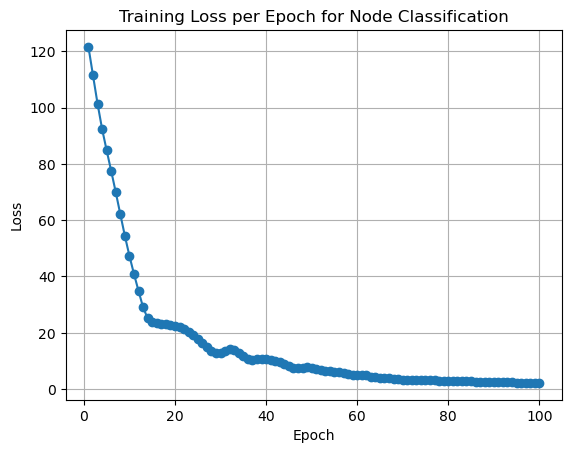

In [49]:
import matplotlib.pyplot as plt

plt.plot(range(1, 101), loss_values, marker='o')
plt.title("Training Loss per Epoch for Node Classification")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [50]:
from sklearn.metrics import accuracy_score

model.eval()
correct = 0
total = 0

for batch in loader:
    out = model(batch) 
    predictions = out.argmax(dim=1)

    # Count correct predictions
    correct += (predictions == batch.y).sum().item()
    total += batch.y.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5094


In [51]:
train_mask = torch.rand(len(data.y)) < 0.8  # 80% for training
val_mask = ~train_mask  # Remaining 20% for validation

# Training loader
train_loader = DataLoader([data], batch_size=1, shuffle=True)

# Model, optimizer, and loss
model = GNN(input_dim=node_features_tensor.size(1), hidden_dim=64, output_dim=len(labels.unique()))
optimizer = Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

/Applications/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [52]:
# Track metrics
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(100):
    # Training
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out[train_mask], batch.y[train_mask])  # Use train_mask
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = loss_fn(out[val_mask], data.y[val_mask])  # Use val_mask
        val_losses.append(val_loss.item())

        # Compute validation accuracy
        val_preds = out[val_mask].argmax(dim=1)
        val_acc = accuracy_score(data.y[val_mask].cpu(), val_preds.cpu())
        val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1, Train Loss: 34.5263, Val Loss: 48.7200, Val Acc: 0.1459
Epoch 2, Train Loss: 48.7996, Val Loss: 39.8895, Val Acc: 0.1297
Epoch 3, Train Loss: 39.7186, Val Loss: 14.3563, Val Acc: 0.1855
Epoch 4, Train Loss: 14.1985, Val Loss: 20.8043, Val Acc: 0.4426
Epoch 5, Train Loss: 20.1934, Val Loss: 27.8520, Val Acc: 0.6213
Epoch 6, Train Loss: 26.8840, Val Loss: 29.9409, Val Acc: 0.6145
Epoch 7, Train Loss: 28.8325, Val Loss: 27.2334, Val Acc: 0.5639
Epoch 8, Train Loss: 26.2111, Val Loss: 20.1905, Val Acc: 0.5734
Epoch 9, Train Loss: 19.4025, Val Loss: 19.4250, Val Acc: 0.1507
Epoch 10, Train Loss: 18.9303, Val Loss: 13.8893, Val Acc: 0.1540
Epoch 11, Train Loss: 13.5057, Val Loss: 12.8693, Val Acc: 0.5825
Epoch 12, Train Loss: 12.3453, Val Loss: 14.3119, Val Acc: 0.5006
Epoch 13, Train Loss: 13.7870, Val Loss: 17.5495, Val Acc: 0.3432
Epoch 14, Train Loss: 17.1113, Val Loss: 17.2235, Val Acc: 0.3804
Epoch 15, Train Loss: 16.7132, Val Loss: 16.6195, Val Acc: 0.5650
Epoch 16, Train Los

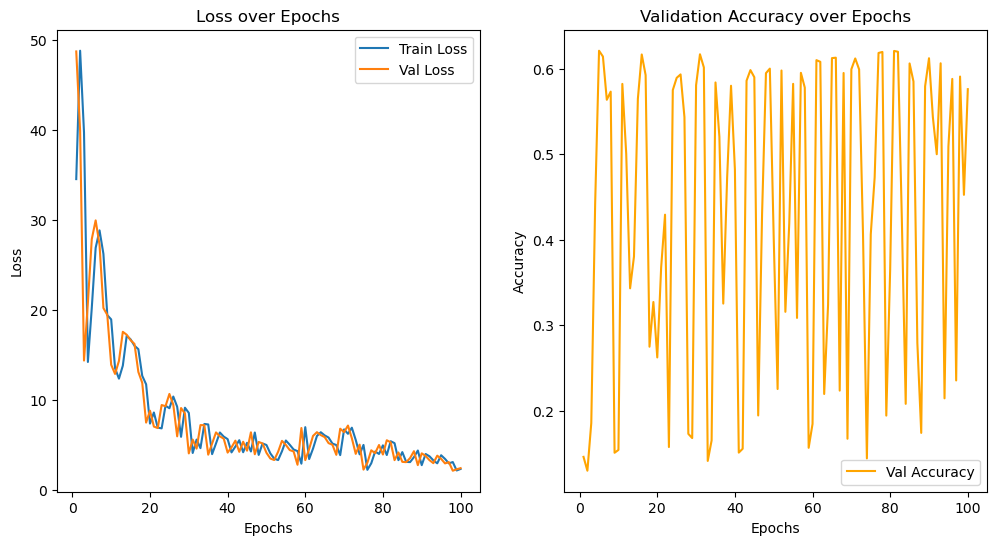

In [53]:
# Plot training/validation losses and validation accuracy
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 101), train_losses, label='Train Loss')
plt.plot(range(1, 101), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 101), val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.show()

brainGNN

In [19]:
edge_attr_numeric = edge_features[['syn_count', 'euclidean_dist']]


In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
edge_attr_numeric[['syn_count', 'euclidean_dist']] = scaler.fit_transform(edge_attr_numeric)


/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_73635/831454580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_attr_numeric[['syn_count', 'euclidean_dist']] = scaler.fit_transform(edge_attr_numeric)


In [21]:
# Convert edge attributes to PyTorch tensor
edge_attr_tensor = torch.tensor(edge_attr_numeric.values, dtype=torch.float)


In [22]:
data = Data(
    x=node_features_tensor,  # Node features
    edge_index=edge_index,   # Edge indices
    edge_attr=edge_attr_tensor,  # Edge attributes
    y=labels  # Node labels for classification
)

In [32]:
import sys
import inspect

import torch
# from torch_geometric.utils import scatter_
from torch_scatter import scatter,scatter_add

special_args = [
    'edge_index', 'edge_index_i', 'edge_index_j', 'size', 'size_i', 'size_j'
]
__size_error_msg__ = ('All tensors which should get mapped to the same source '
                      'or target nodes must be of same size in dimension 0.')

is_python2 = sys.version_info[0] < 3
getargspec = inspect.getargspec if is_python2 else inspect.getfullargspec


class MyMessagePassing(torch.nn.Module):
    r"""Base class for creating message passing layers
    .. math::
        \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
        \square_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
        \left(\mathbf{x}_i, \mathbf{x}_j,\mathbf{e}_{i,j}\right) \right),
    where :math:`\square` denotes a differentiable, permutation invariant
    function, *e.g.*, sum, mean or max, and :math:`\gamma_{\mathbf{\Theta}}`
    and :math:`\phi_{\mathbf{\Theta}}` denote differentiable functions such as
    MLPs.
    See `here <https://pytorch-geometric.readthedocs.io/en/latest/notes/
    create_gnn.html>`__ for the accompanying tutorial.
    Args:
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"` or :obj:`"max"`).
            (default: :obj:`"add"`)
        flow (string, optional): The flow direction of message passing
            (:obj:`"source_to_target"` or :obj:`"target_to_source"`).
            (default: :obj:`"source_to_target"`)
        node_dim (int, optional): The axis along which to propagate.
            (default: :obj:`0`)
    """
    def __init__(self, aggr='add', flow='source_to_target', node_dim=0):
        super(MyMessagePassing, self).__init__()

        self.aggr = aggr
        assert self.aggr in ['add', 'mean', 'max']

        self.flow = flow
        assert self.flow in ['source_to_target', 'target_to_source']

        self.node_dim = node_dim
        assert self.node_dim >= 0

        self.__message_args__ = getargspec(self.message)[0][1:]
        self.__special_args__ = [(i, arg)
                                 for i, arg in enumerate(self.__message_args__)
                                 if arg in special_args]
        self.__message_args__ = [
            arg for arg in self.__message_args__ if arg not in special_args
        ]
        self.__update_args__ = getargspec(self.update)[0][2:]

    def propagate(self, edge_index, size=None, **kwargs):
        r"""The initial call to start propagating messages.
        Args:
            edge_index (Tensor): The indices of a general (sparse) assignment
                matrix with shape :obj:`[N, M]` (can be directed or
                undirected).
            size (list or tuple, optional): The size :obj:`[N, M]` of the
                assignment matrix. If set to :obj:`None`, the size is tried to
                get automatically inferred and assumed to be symmetric.
                (default: :obj:`None`)
            **kwargs: Any additional data which is needed to construct messages
                and to update node embeddings.
        """

        dim = self.node_dim
        size = [None, None] if size is None else list(size)
        assert len(size) == 2

        i, j = (0, 1) if self.flow == 'target_to_source' else (1, 0)
        ij = {"_i": i, "_j": j}

        message_args = []
        for arg in self.__message_args__:
            if arg[-2:] in ij.keys():
                tmp = kwargs.get(arg[:-2], None)
                if tmp is None:  # pragma: no cover
                    message_args.append(tmp)
                else:
                    idx = ij[arg[-2:]]
                    if isinstance(tmp, tuple) or isinstance(tmp, list):
                        assert len(tmp) == 2
                        if tmp[1 - idx] is not None:
                            if size[1 - idx] is None:
                                size[1 - idx] = tmp[1 - idx].size(dim)
                            if size[1 - idx] != tmp[1 - idx].size(dim):
                                raise ValueError(__size_error_msg__)
                        tmp = tmp[idx]

                    if tmp is None:
                        message_args.append(tmp)
                    else:
                        if size[idx] is None:
                            size[idx] = tmp.size(dim)
                        if size[idx] != tmp.size(dim):
                            raise ValueError(__size_error_msg__)

                        tmp = torch.index_select(tmp, dim, edge_index[idx])
                        message_args.append(tmp)
            else:
                message_args.append(kwargs.get(arg, None))

        size[0] = size[1] if size[0] is None else size[0]
        size[1] = size[0] if size[1] is None else size[1]

        kwargs['edge_index'] = edge_index
        kwargs['size'] = size

        for (idx, arg) in self.__special_args__:
            if arg[-2:] in ij.keys():
                message_args.insert(idx, kwargs[arg[:-2]][ij[arg[-2:]]])
            else:
                message_args.insert(idx, kwargs[arg])

        update_args = [kwargs[arg] for arg in self.__update_args__]

        out = self.message(*message_args)
        # out = scatter_(self.aggr, out, edge_index[i], dim, dim_size=size[i])
        out = scatter_add(out, edge_index[i], dim, dim_size=size[i])
        out = self.update(out, *update_args)

        return out

    def message(self, x_j):  # pragma: no cover
        r"""Constructs messages to node :math:`i` in analogy to
        :math:`\phi_{\mathbf{\Theta}}` for each edge in
        :math:`(j,i) \in \mathcal{E}` if :obj:`flow="source_to_target"` and
        :math:`(i,j) \in \mathcal{E}` if :obj:`flow="target_to_source"`.
        Can take any argument which was initially passed to :meth:`propagate`.
        In addition, tensors passed to :meth:`propagate` can be mapped to the
        respective nodes :math:`i` and :math:`j` by appending :obj:`_i` or
        :obj:`_j` to the variable name, *.e.g.* :obj:`x_i` and :obj:`x_j`.
        """

        return x_j

    def update(self, aggr_out):  # pragma: no cover
        r"""Updates node embeddings in analogy to
        :math:`\gamma_{\mathbf{\Theta}}` for each node
        :math:`i \in \mathcal{V}`.
        Takes in the output of aggregation as first argument and any argument
        which was initially passed to :meth:`propagate`."""

        return aggr_out

ModuleNotFoundError: No module named 'torch_scatter'

In [31]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter
# from net.brainmsgpassing import MyMessagePassing
from torch_geometric.utils import add_remaining_self_loops,softmax

from torch_geometric.typing import (OptTensor)

from net.inits import uniform


class MyNNConv(MyMessagePassing):
    def __init__(self, in_channels, out_channels, nn, normalize=False, bias=True,
                 **kwargs):
        super(MyNNConv, self).__init__(aggr='mean', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.nn = nn
        #self.weight = Parameter(torch.Tensor(self.in_channels, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
#        uniform(self.in_channels, self.weight)
        uniform(self.in_channels, self.bias)

    def forward(self, x, edge_index, edge_weight=None, pseudo= None, size=None):
        """"""
        edge_weight = edge_weight.squeeze()
        if size is None and torch.is_tensor(x):
            edge_index, edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, 1, x.size(0))

        weight = self.nn(pseudo).view(-1, self.in_channels, self.out_channels)
        if torch.is_tensor(x):
            x = torch.matmul(x.unsqueeze(1), weight).squeeze(1)
        else:
            x = (None if x[0] is None else torch.matmul(x[0].unsqueeze(1), weight).squeeze(1),
                 None if x[1] is None else torch.matmul(x[1].unsqueeze(1), weight).squeeze(1))

        # weight = self.nn(pseudo).view(-1, self.out_channels,self.in_channels)
        # if torch.is_tensor(x):
        #     x = torch.matmul(x.unsqueeze(1), weight.permute(0,2,1)).squeeze(1)
        # else:
        #     x = (None if x[0] is None else torch.matmul(x[0].unsqueeze(1), weight).squeeze(1),
        #          None if x[1] is None else torch.matmul(x[1].unsqueeze(1), weight).squeeze(1))

        return self.propagate(edge_index, size=size, x=x,
                              edge_weight=edge_weight)

    def message(self, edge_index_i, size_i, x_j, edge_weight, ptr: OptTensor):
        edge_weight = softmax(edge_weight, edge_index_i, ptr, size_i)
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def update(self, aggr_out):
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        if self.normalize:
            aggr_out = F.normalize(aggr_out, p=2, dim=-1)
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

ModuleNotFoundError: No module named 'net'

In [25]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import (add_self_loops, sort_edge_index,
                                   remove_self_loops, to_dense_adj, dense_to_sparse)
# from torch_sparse import spspmm

from net.braingraphconv import MyNNConv

class Network(torch.nn.Module):
    def __init__(self, indim, ratio, nclass, k=8, R=200):
        '''

        :param indim: (int) node feature dimension
        :param ratio: (float) pooling ratio in (0,1)
        :param nclass: (int)  number of classes
        :param k: (int) number of communities
        :param R: (int) number of ROIs
        '''
        super(Network, self).__init__()

        self.indim = indim
        self.dim1 = 32
        self.dim2 = 32
        self.dim3 = 512
        self.dim4 = 256
        self.dim5 = 8
        self.k = k
        self.R = R

        self.n1 = nn.Sequential(nn.Linear(self.R, self.k, bias=False), nn.ReLU(), nn.Linear(self.k, self.dim1 * self.indim))
        self.conv1 = MyNNConv(self.indim, self.dim1, self.n1, normalize=False)
        self.pool1 = TopKPooling(self.dim1, ratio=ratio, multiplier=1, nonlinearity=torch.sigmoid)
        self.n2 = nn.Sequential(nn.Linear(self.R, self.k, bias=False), nn.ReLU(), nn.Linear(self.k, self.dim2 * self.dim1))
        self.conv2 = MyNNConv(self.dim1, self.dim2, self.n2, normalize=False)
        self.pool2 = TopKPooling(self.dim2, ratio=ratio, multiplier=1, nonlinearity=torch.sigmoid)

        #self.fc1 = torch.nn.Linear((self.dim2) * 2, self.dim2)
        self.fc1 = torch.nn.Linear((self.dim1+self.dim2)*2, self.dim2)
        self.bn1 = torch.nn.BatchNorm1d(self.dim2)
        self.fc2 = torch.nn.Linear(self.dim2, self.dim3)
        self.bn2 = torch.nn.BatchNorm1d(self.dim3)
        self.fc3 = torch.nn.Linear(self.dim3, nclass)




    def forward(self, x, edge_index, batch, edge_attr, pos):

        x = self.conv1(x, edge_index, edge_attr, pos)
        x, edge_index, edge_attr, batch, perm, score1 = self.pool1(x, edge_index, edge_attr, batch)

        pos = pos[perm]
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        edge_attr = edge_attr.squeeze()
        edge_index, edge_attr = self.augment_adj(edge_index, edge_attr, x.size(0))

        x = self.conv2(x, edge_index, edge_attr, pos)
        x, edge_index, edge_attr, batch, perm, score2 = self.pool2(x, edge_index,edge_attr, batch)

        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = torch.cat([x1,x2], dim=1)
        x = self.bn1(F.relu(self.fc1(x)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.bn2(F.relu(self.fc2(x)))
        x= F.dropout(x, p=0.5, training=self.training)
        x = F.log_softmax(self.fc3(x), dim=-1)

        return x,self.pool1.weight,self.pool2.weight, torch.sigmoid(score1).view(x.size(0),-1), torch.sigmoid(score2).view(x.size(0),-1)

    # def augment_adj(self, edge_index, edge_weight, num_nodes):
    #     edge_index, edge_weight = add_self_loops(edge_index, edge_weight,
    #                                              num_nodes=num_nodes)
    #     edge_index, edge_weight = sort_edge_index(edge_index, edge_weight,
    #                                               num_nodes)
    #     edge_index, edge_weight = spspmm(edge_index, edge_weight, edge_index,
    #                                      edge_weight, num_nodes, num_nodes,
    #                                      num_nodes)
    #     edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
    #     return edge_index, edge_weight

    def augment_adj(self, edge_index, edge_weight, num_nodes):
        # Convert sparse edge representation to dense adjacency matrix
        adj = to_dense_adj(edge_index, edge_attr=edge_weight, max_num_nodes=num_nodes)[0]

        # Add self-loops
        adj += torch.eye(num_nodes, device=adj.device)

        # Normalize adjacency matrix (optional, depending on use case)
        row_sum = adj.sum(dim=-1, keepdim=True)
        adj /= row_sum

        # Convert dense adjacency matrix back to sparse representation
        edge_index, edge_weight = dense_to_sparse(adj)

        # Remove self-loops (if needed)
        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)

        return edge_index, edge_weight



In [28]:
num_nodes = node_features_tensor.size(0)
num_features = node_features_tensor.size(1)
num_classes = len(torch.unique(labels))  # Number of classes in your data
pos = torch.zeros(num_nodes, 3)  # Placeholder for positional info, if applicable


In [29]:
indim = num_features  # Feature dimension
ratio = 0.5  # Pooling ratio
nclass = num_classes  # Number of output classes
k = 8  # Number of communities
R = 200  # Number of ROIs

model = Network(indim=indim, ratio=ratio, nclass=nclass, k=k, R=R)
optimizer = Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Step 3: Training and Validation Split
loader = DataLoader([data], batch_size=1, shuffle=True)

# Placeholder for validation split (replace with actual validation logic)
train_loader = loader
val_loader = loader

# Step 4: Training Loop
train_losses = []
val_losses = []

for epoch in range(50):  # Train for 50 epochs
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out, _, _, _, _ = model(batch.x, batch.edge_index, batch.batch, batch.edge_attr, batch.pos)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation Phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            out, _, _, _, _ = model(batch.x, batch.edge_index, batch.batch, batch.edge_attr, batch.pos)
            loss = loss_fn(out, batch.y)
            val_loss += loss.item()

            # Calculate Accuracy
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)

    val_losses.append(val_loss / len(val_loader))
    accuracy = correct / total

    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {accuracy:.4f}")

# Step 5: Plot Losses (optional)
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'MyNNConv' is not defined

In [18]:
num_nodes = node_features_tensor.size(0)
num_features = node_features_tensor.size(1)
num_classes = len(torch.unique(labels))  # Number of classes in your data
pos = torch.zeros(num_nodes, 3)  # Placeholder for positional info, if applicable

data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr, y=labels, pos=pos)


NameError: name 'node_labels' is not defined

predicting connectivity -> edge classification. synapse counts

play around with connectivity tags

In [29]:
data.edge_attr = torch.tensor(edge_features[['syn_count', 'euclidean_dist']].values, dtype=torch.float)

In [30]:
edge_features['syn_count'].nunique()

548

In [52]:
class EdgeGNN(torch.nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim, output_dim):
        super(EdgeGNN, self).__init__()
        self.edge_linear = Linear(edge_dim, hidden_dim)  # Transform edge attributes to hidden_dim
        self.conv1 = EdgeConv(nn=Linear(input_dim + hidden_dim, hidden_dim))  # Combine node and edge features
        self.conv2 = EdgeConv(nn=Linear(hidden_dim, output_dim))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        edge_embedding = self.edge_linear(edge_attr)  # Transform edge attributes to hidden_dim

        # Aggregate edge embeddings for each node
        aggregated_edge_embeddings = torch.zeros_like(x)
        aggregated_edge_embeddings.index_add_(
            0, edge_index[0], edge_embedding
        )  # Sum edge embeddings for each node based on source nodes

        # Concatenate node features with aggregated edge embeddings
        x = torch.cat([x, aggregated_edge_embeddings], dim=-1)
        x = self.conv1(x, edge_index)  # Perform message passing
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [53]:
num_edge_classes = 2
model = EdgeGNN(input_dim=node_features_tensor.size(1), 
            edge_dim=data.edge_attr.size(1),  # Include edge feature dimensions
            hidden_dim=64, 
            output_dim=num_edge_classes)


In [54]:
loss_fn = nn.CrossEntropyLoss()

losses = []
for epoch in range(100):
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)  # Includes edge_index and edge_attr
        loss = loss_fn(out, batch.edge_y)  # Edge-level labels
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


RuntimeError: The size of tensor a (6) must match the size of tensor b (64) at non-singleton dimension 0

In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
with torch.no_grad():
    preds = model(data).argmax(dim=1)  # Predicted edge classes
    accuracy = accuracy_score(data.edge_y.cpu(), preds.cpu())
    print(f"Accuracy: {accuracy}")


more complicated our own made brainGNN

In [39]:
from sklearn.model_selection import train_test_split

indices = torch.arange(len(labels)) 
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_mask = torch.zeros(len(labels), dtype=torch.bool)
val_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[train_indices] = True
val_mask[val_indices] = True

data.train_mask = train_mask
data.val_mask = val_mask

val_data = data

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
from torch_geometric.data import DataLoader
from torch.optim import Adam

class AdvancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdvancedGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim) 
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(self.bn1(x))
        x = self.conv2(x, edge_index)
        x = F.relu(self.bn2(x))
        x = self.dropout(x) 
        x = self.conv3(x, edge_index)
        
        return x


In [57]:
val_loader = DataLoader([val_data], batch_size=32, shuffle=False)  # Validation data

train_mask = torch.rand(len(data.y)) < 0.8  # 80% for training
val_mask = ~train_mask  # Remaining 20% for validation

# Training loader
train_loader = DataLoader([data], batch_size=1, shuffle=True)

# Model setup
model = AdvancedGNN(
    input_dim=node_features_tensor.size(1),
    hidden_dim=64,
    output_dim=len(labels.unique())
)
optimizer = Adam(model.parameters(), lr=0.001) 
loss_fn = nn.CrossEntropyLoss()

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(100):
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch) 

        loss = loss_fn(out[train_mask], batch.y[train_mask])
        
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = loss_fn(out[val_mask], data.y[val_mask])  # Use val_mask
        val_losses.append(val_loss.item())

        val_preds = out[val_mask].argmax(dim=1)
        val_acc = accuracy_score(data.y[val_mask].cpu(), val_preds.cpu())
        val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1, Train Loss: 2.1830, Val Loss: 2.2457, Val Acc: 0.1067
Epoch 2, Train Loss: 2.0790, Val Loss: 1.9851, Val Acc: 0.1064
Epoch 3, Train Loss: 2.0439, Val Loss: 1.8749, Val Acc: 0.1045
Epoch 4, Train Loss: 2.0068, Val Loss: 1.8159, Val Acc: 0.1282
Epoch 5, Train Loss: 1.9754, Val Loss: 1.7746, Val Acc: 0.4282
Epoch 6, Train Loss: 1.8706, Val Loss: 1.7457, Val Acc: 0.5527
Epoch 7, Train Loss: 1.8735, Val Loss: 1.7240, Val Acc: 0.5721
Epoch 8, Train Loss: 1.8224, Val Loss: 1.7065, Val Acc: 0.5814
Epoch 9, Train Loss: 1.7839, Val Loss: 1.6908, Val Acc: 0.5820
Epoch 10, Train Loss: 1.7683, Val Loss: 1.6760, Val Acc: 0.5813
Epoch 11, Train Loss: 1.7421, Val Loss: 1.6609, Val Acc: 0.5826
Epoch 12, Train Loss: 1.7233, Val Loss: 1.6456, Val Acc: 0.5845
Epoch 13, Train Loss: 1.7062, Val Loss: 1.6313, Val Acc: 0.5874
Epoch 14, Train Loss: 1.6795, Val Loss: 1.6182, Val Acc: 0.5913
Epoch 15, Train Loss: 1.6529, Val Loss: 1.6060, Val Acc: 0.5942
Epoch 16, Train Loss: 1.6698, Val Loss: 1.5942, V

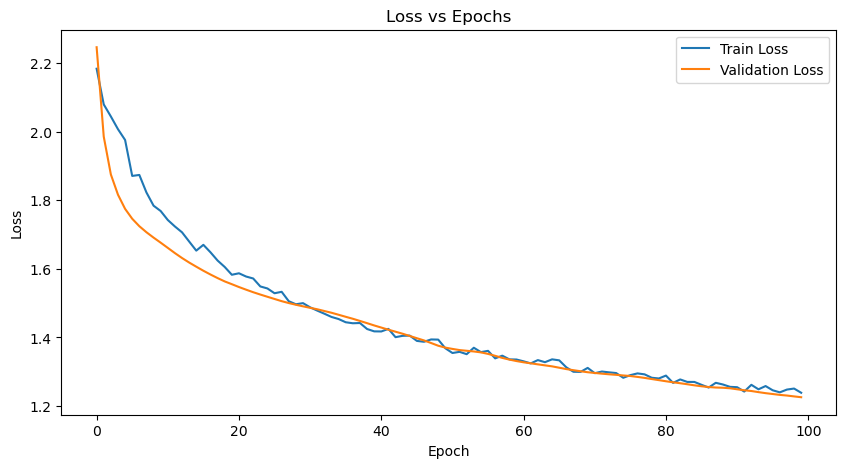

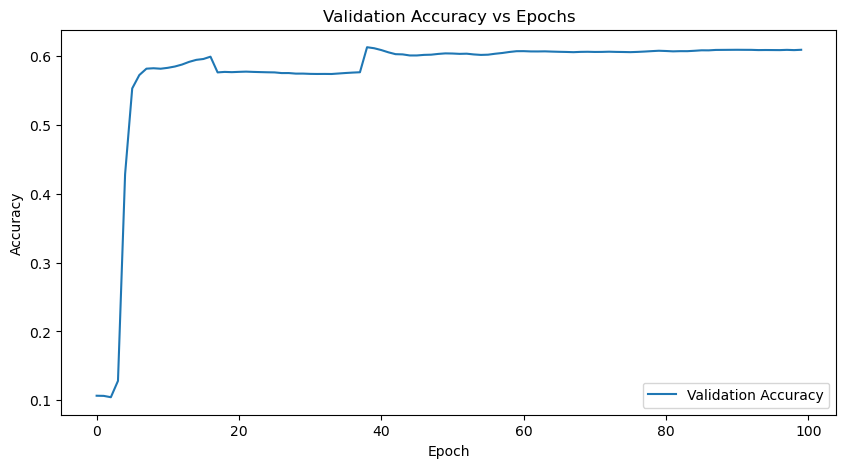

In [58]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy vs Epochs')
plt.show()
